In [1]:
# import environment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from openai import OpenAI
from openai import OpenAIError

In [2]:
# Load api key
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# Raise error if missing
if api_key is None:
    raise ValueError("API key not found. Please set the OPENAI_API_KEY environment variable.")

# Create client
client = OpenAI(api_key=api_key)

In [3]:
# Load Data
df = pd.read_excel("test.xlsx", sheet_name="in")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [4]:
# Remove rows with missing or empty body
df = df[df['body'].notnull()]
df = df[df['body'].str.strip().str.len() > 10]

# Only if the same email appears more than once
df = df.drop_duplicates(subset='body')

In [5]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    text = re.sub(r'[\n\r\t]+', ' ', text)        # Replace newlines and tabs with space
    text = re.sub(r'[^\w\s]', '', text)           # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text)              # Replace multiple spaces with a single space
    return text.strip()

# Text preprocessing function with tokenization and lemmatization
def preprocess_text(text):
    text = clean_text(text)                       # Step 1: Clean raw text
    tokens = word_tokenize(text.lower())          # Step 2: Lowercase and tokenize
    filtered = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
                                                  # Step 3: Remove stopwords and non-alpha tokens
    return " ".join(filtered)

# Apply preprocessing to the 'body' column
df['processed_body'] = df['body'].apply(preprocess_text)

# Display the first few rows of the processed DataFrame
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WYF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WYF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WYF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\WYF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\WYF\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Subject,body,date,from,processed_body
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,enronoptions announcement updated enronoptions...
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,marc unfortunately today going work revenue mo...
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,wednesday june central time u canada cst
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,thinking papasitos meet somewhere closer time ...
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,since never gave last time bet cutexas figured...


### Task 1: Sentiment Labeling

In [7]:
from tqdm import tqdm
import time

# GPT classifier with rate limiting
def classify_email(text):
    try:
        prompt = f"""
You are a sentiment analysis engine. 
Classify the **overall sentiment** of the following email content as one of these three categories:
- Positive
- Neutral
- Negative

Only respond with one of those three words.

Message:
{text}

Sentiment:"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )
        time.sleep(0.5)  # Rate limiting: wait 0.5 seconds between calls
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error: {e}")
        return "Error"


# Run classification
tqdm.pandas()
df['sentiment'] = df['processed_body'].progress_apply(classify_email)

# Save to file under Output directory
df.to_csv("output/labeled_sentiment.csv", index=False)
print("Sentiment labeling done. File saved: labeled_sentiment.csv")


100%|██████████| 1511/1511 [26:04<00:00,  1.04s/it] 

Sentiment labeling done. File saved: labeled_sentiment.csv


In [8]:
# Check the output
df_sen = pd.read_csv("output/labeled_sentiment.csv")
df_sen.head()

,Subject,body,date,from,processed_body,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,enronoptions announcement updated enronoptions...,Neutral
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,marc unfortunately today going work revenue mo...,Neutral
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,wednesday june central time u canada cst,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,thinking papasitos meet somewhere closer time ...,Neutral
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,since never gave last time bet cutexas figured...,Neutral


### Task 2: Exploratory Data Analysis (EDA)

In [9]:
# load environment
import seaborn as sns

In [10]:
# Load the data
df = pd.read_csv("output/labeled_sentiment.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create a new column for the month
df['month'] = df['date'].dt.to_period('M')

In [11]:
# Clean the sentiment column
import re

def extract_sentiment(text):
    match = re.search(r'\b(Positive|Negative|Neutral)\b', str(text), re.IGNORECASE)
    return match.group(1).capitalize() if match else "Unknown"

df['sentiment_clean'] = df['sentiment'].apply(extract_sentiment)


In [12]:
print("Basic Info:")
print("Total Records:", len(df))
print("Missing values:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)
print("\nSentiment Distribution:\n", df['sentiment'].value_counts())

Basic Info:
Total Records: 1511
Missing values:
 Subject             0
body                0
date                0
from                0
processed_body     25
sentiment           0
month               0
sentiment_clean     0
dtype: int64
Data types:
 Subject                    object
body                       object
date               datetime64[ns]
from                       object
processed_body             object
sentiment                  object
month                   period[M]
sentiment_clean            object
dtype: object

Sentiment Distribution:
 sentiment
Neutral     1312
Positive     104
Negative      95
Name: count, dtype: int64


C:\Users\WYF\AppData\Local\Temp\ipykernel_39324\220127780.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'], palette=colors)


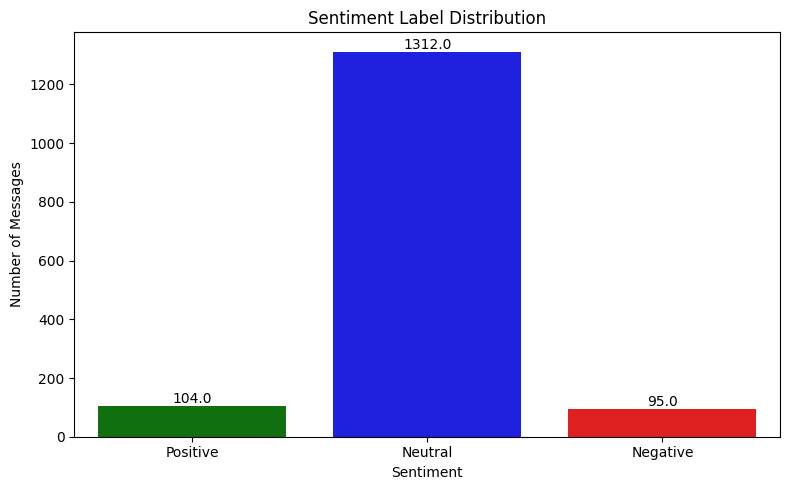

In [ ]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 5))
colors = ["green", "blue", "red"]
ax = sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'], palette=colors)

# Set the title and labels
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.tight_layout()

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

# Save and show the plot
plt.savefig("Visualization/sentiment_distribution_plot.png")
plt.show()

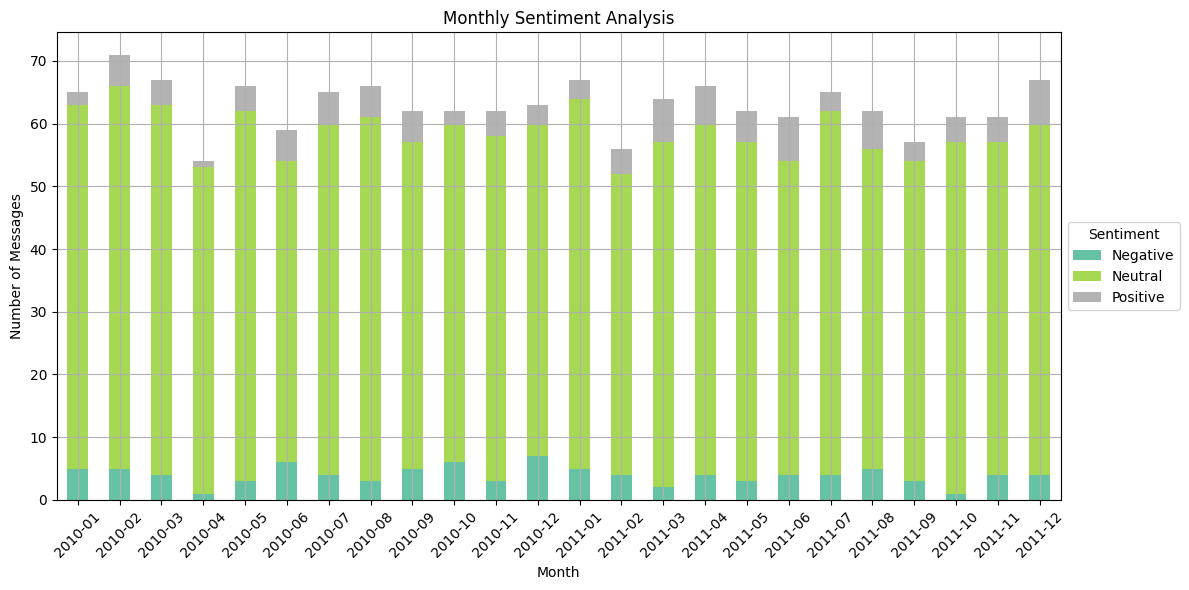

In [ ]:
# Monthly sentiment analysis
monthly_sentiment = df.groupby(['month', 'sentiment_clean']).size().unstack(fill_value=0)

# Plotting the monthly sentiment analysis
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Monthly Sentiment Analysis")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.legend(title="Sentiment", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(bottom=0.2, right=0.8)
plt.tight_layout()

# Save and show the plot
plt.savefig("Visualization/monthly_sentiment_analysis.png")
plt.show()

### Task 3: Employee Score Calculation

In [15]:
# Give the sentiment scores
def sentiment_score(sentiment):
    if sentiment == "Positive":
        return 1
    elif sentiment == "Negative":
        return -1
    else:
        return 0

df['sentiment_score'] = df['sentiment_clean'].apply(sentiment_score)

In [17]:
# Convert the 'Order Date' column to period
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period("M")

# Give the monthly sentiment score
monthly_scores = df.groupby(['from', 'month'])['sentiment_score'].sum().reset_index()

monthly_scores.rename(columns={'from': 'employee', 'sentiment_score': 'monthly_score'}, inplace=True)

# Print the monthly scores
print(monthly_scores.head())

# Save the monthly scores to a CSV file
monthly_scores.to_csv("Output/monthly_sentiment_scores.csv", index=False)
print("Monthly sentiment scores saved to monthly_sentiment_scores.csv")

                      employee    month  monthly_score
0  bobette.riner@ipgdirect.com  2010-01              0
1  bobette.riner@ipgdirect.com  2010-02             -1
2  bobette.riner@ipgdirect.com  2010-03              0
3  bobette.riner@ipgdirect.com  2010-04              0
4  bobette.riner@ipgdirect.com  2010-05              1
Monthly sentiment scores saved to monthly_sentiment_scores.csv


### Task 4: Employee Ranking

In [18]:
# Positive and Negative dataframes
df_positive = monthly_scores.copy()
df_negative = monthly_scores.copy()

In [19]:
# Positive
df_positive.sort_values(by = ['month', 'monthly_score', 'employee'], 
                         ascending=[True, False, True], inplace=True)

# Negative
df_negative.sort_values(by = ['month', 'monthly_score', 'employee'], 
                         ascending=[True, True, True], inplace=True)

In [20]:
# Top 3
top_3_positive = df_positive.groupby('month').head(3).copy()
top_3_positive["rank"] = "Most Positive"

top_3_negative = df_negative.groupby('month').head(3).copy()
top_3_negative["rank"] = "Most Negative"

# Combine the two dataframes
employee_rankings = pd.concat([top_3_positive, top_3_negative], ignore_index=True)
employee_rankings = employee_rankings[['month', 'employee', 'monthly_score', 'rank']]

# Save the employee rankings to a CSV file
employee_rankings.to_csv("Output/employee_rankings.csv", index=False)
print("Employee rankings saved to employee_rankings.csv")

# Print the employee rankings
print(employee_rankings.head(10))

Employee rankings saved to employee_rankings.csv
     month                     employee  monthly_score           rank
0  2010-01          eric.bass@enron.com              2  Most Positive
1  2010-01  bobette.riner@ipgdirect.com              0  Most Positive
2  2010-01       don.baughman@enron.com              0  Most Positive
3  2010-02      johnny.palmer@enron.com              2  Most Positive
4  2010-02       don.baughman@enron.com              1  Most Positive
5  2010-02      lydia.delgado@enron.com              1  Most Positive
6  2010-03          eric.bass@enron.com              1  Most Positive
7  2010-03  bobette.riner@ipgdirect.com              0  Most Positive
8  2010-03       don.baughman@enron.com              0  Most Positive
9  2010-04      rhonda.denton@enron.com              1  Most Positive


### Task 5: Flight Risk Identification

In [21]:
# Filter the negative messages
df_negative_emails = df[df['sentiment_clean'] == 'Negative'].copy()

# Ensure the 'date' column is in datetime format
df_negative_emails['date'] = pd.to_datetime(df_negative_emails['date'], errors='coerce')

# Conclut into set
risk_employees = set()

# Check for more than 4 negative messages in a month
for employee, group in df_negative_emails.groupby('from'):
    dates = group['date'].dropna().sort_values().reset_index(drop=True)
    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=30)
        count = dates[(dates >= window_start) & (dates < window_end)].count()
        if count >= 4:
            risk_employees.add(employee)
            break  # No need to check further for this employee
                   

# Add the risk employees to the dataframe
risk_employees_df = pd.DataFrame({
        'employee': list(risk_employees),
        'risks': True
})

# Output the risk employees
risk_employees_df.to_csv("Output/risk_employees.csv", index=False)
print("Risk employees saved to risk_employees.csv")

# Print the risk employees
print(risk_employees_df.head())

Risk employees saved to risk_employees.csv
               employee  risks
0  sally.beck@enron.com   True


### Task 6: Predictive Modeling

In [22]:
# Import models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

In [24]:
# Read the data
df = pd.read_csv("Output/monthly_sentiment_scores.csv")

# Time series
df['month'] = pd.PeriodIndex(df['month'], freq='M').to_timestamp()
df['month_num'] = df['month'].map(lambda x: x.toordinal())

# Monthly scores
monthly_scores = df.copy()

message_count = df.groupby(['employee', 'month']).size().reset_index(name='message_count')
monthly_scores = monthly_scores.merge(message_count, on=['employee', 'month'], how='left')

monthly_scores['positive_count'] = (monthly_scores['monthly_score'] > 0).astype(int)
monthly_scores['negative_count'] = (monthly_scores['monthly_score'] < 0).astype(int)
monthly_scores['total_count'] = 1

monthly_scores['pos_ratio'] = monthly_scores['positive_count']
monthly_scores['neg_ratio'] = monthly_scores['negative_count']

# Past three months scores for each employee
monthly_scores.sort_values(by=['employee', 'month'], inplace=True)
monthly_scores['rolling_avg_3'] = monthly_scores.groupby('employee')['monthly_score']\
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# employee_id
monthly_scores['employee_id'] = LabelEncoder().fit_transform(monthly_scores['employee'])

#### Linear

Linear Regression R^2: 0.7946
Linear Regression RMSE: 0.4302


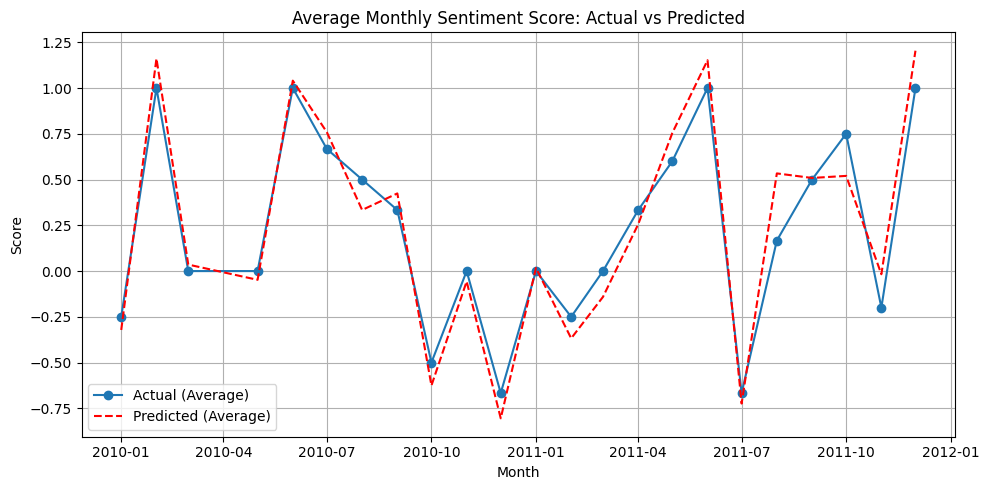

In [ ]:
# Variables
features = ['month_num', 'message_count', 'pos_ratio', 'neg_ratio', 'rolling_avg_3', 'employee_id']
X = monthly_scores[features]
y = monthly_scores['monthly_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression R^2: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

# Create temporary DataFrame for visualization (without modifying original)
viz_df = X_test.copy()
viz_df["month"] = monthly_scores.loc[X_test.index, "month"]
viz_df["actual_score"] = y_test
viz_df["predicted_score"] = y_pred_lr

# Group by month for average actual and predicted scores
monthly_avg = viz_df.groupby("month")[["actual_score", "predicted_score"]].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg['month'], monthly_avg['actual_score'], label='Actual (Average)', marker='o')
plt.plot(monthly_avg['month'], monthly_avg['predicted_score'], label='Predicted (Average)', linestyle='--', color='red')
plt.title("Average Monthly Sentiment Score: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Visualization/average_sentiment_trend.png")
plt.show()


#### Logistic Regression

Logistic Regression Accuracy: 0.3380
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.34      1.00      0.51        24

    accuracy                           0.34        71
   macro avg       0.17      0.50      0.25        71
weighted avg       0.11      0.34      0.17        71



c:\Users\WYF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WYF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WYF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

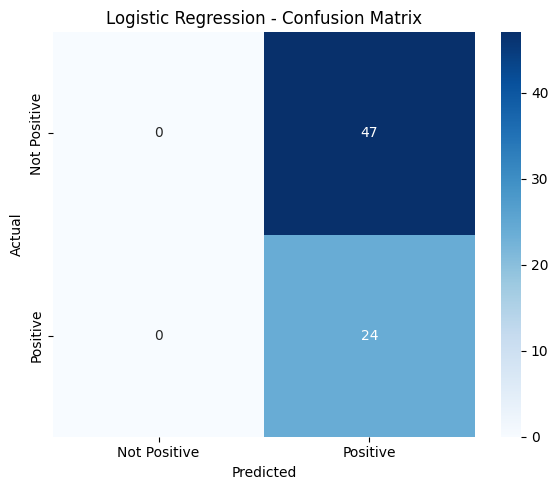

In [ ]:
# Prepare binary classification target
monthly_scores['is_positive'] = (monthly_scores['monthly_score'] > 0).astype(int)
y_class = monthly_scores['is_positive']

# Features and split
features = ['month_num', 'message_count', 'pos_ratio', 'neg_ratio', 'rolling_avg_3', 'employee_id']
X = monthly_scores[features]

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.3, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=2000, class_weight='balanced')
log_model.fit(X_train, y_train_class)

# Predict
y_pred_log = log_model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test_class, y_pred_log)
print(f"Logistic Regression Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test_class, y_pred_log))

#  Confusion matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_log)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Positive', 'Positive'],
            yticklabels=['Not Positive', 'Positive'])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
os.makedirs("Visualization", exist_ok=True)
plt.savefig("Visualization/logistic_confusion_matrix.png")
plt.show()


#### RF

Random Forest R²: 0.7567
Random Forest RMSE: 0.4682


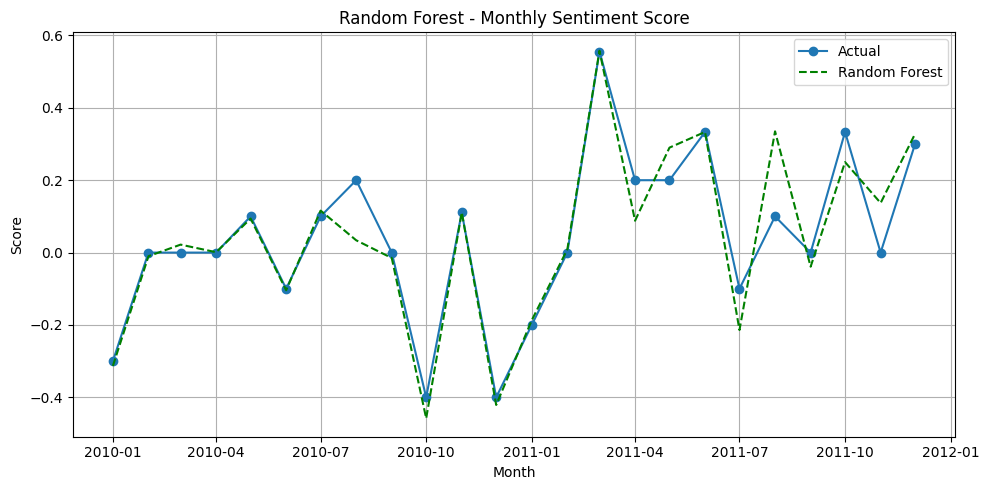

In [ ]:
# Define features and target
features = ['month_num', 'message_count', 'pos_ratio', 'neg_ratio', 'rolling_avg_3', 'employee_id']
X = monthly_scores[features]
y = monthly_scores['monthly_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)

print(f"Random Forest R²: {r2:.4f}")
print(f"Random Forest RMSE: {rmse:.4f}")

# ✅ Create a clean copy for visualization only
viz_rf = X.copy()
viz_rf["month"] = monthly_scores["month"]
viz_rf["monthly_score"] = y
viz_rf["rf_pred"] = rf_model.predict(X)

# Group by month to get average trend
monthly_avg_rf = viz_rf.groupby("month")[["monthly_score", "rf_pred"]].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_rf['month'], monthly_avg_rf['monthly_score'], label='Actual', marker='o')
plt.plot(monthly_avg_rf['month'], monthly_avg_rf['rf_pred'], label='Random Forest', linestyle='--', color='green')
plt.title("Random Forest - Monthly Sentiment Score")
plt.xlabel("Month")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
os.makedirs("Visualization", exist_ok=True)
plt.savefig("Visualization/random_forest_monthly_trend.png")
plt.show()


#### MLP

MLP R²: 0.7916
MLP RMSE: 0.4334


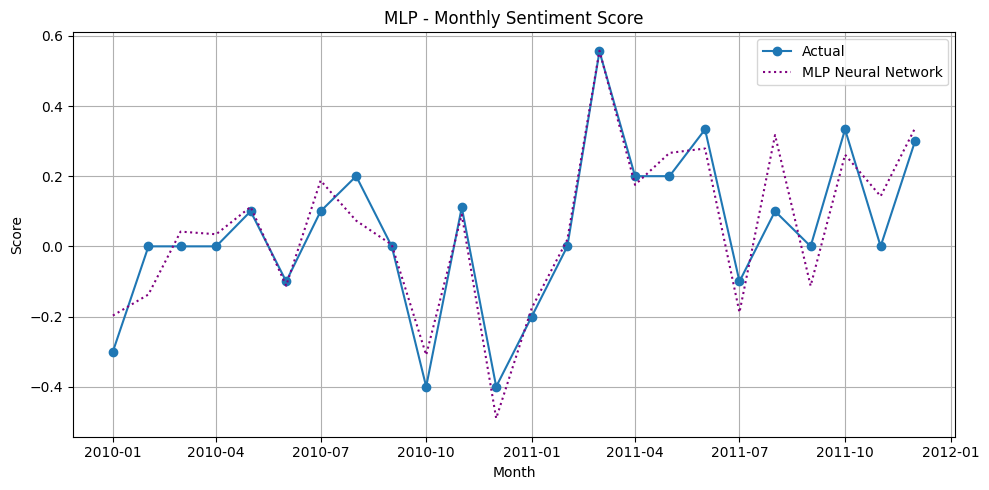

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train MLP model
mlp_model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(32, 16), alpha=0.0001, max_iter=10000,
                 early_stopping=True, random_state=42)
)

mlp_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp_model.predict(X_test)
print(f"MLP R²: {r2_score(y_test, y_pred_mlp):.4f}")
print(f"MLP RMSE: {mean_squared_error(y_test, y_pred_mlp, squared=False):.4f}")

# Create a temporary copy for visualization
viz_mlp = X.copy()
viz_mlp["month"] = monthly_scores["month"]
viz_mlp["monthly_score"] = y
viz_mlp["mlp_pred"] = mlp_model.predict(X)

# Group by month to average predictions
monthly_avg_mlp = viz_mlp.groupby("month")[["monthly_score", "mlp_pred"]].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_mlp['month'], monthly_avg_mlp['monthly_score'], label='Actual', marker='o')
plt.plot(monthly_avg_mlp['month'], monthly_avg_mlp['mlp_pred'], label='MLP Neural Network', linestyle=':', color='purple')
plt.title("MLP - Monthly Sentiment Score")
plt.xlabel("Month")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
os.makedirs("Visualization", exist_ok=True)
plt.savefig("Visualization/mlp_monthly_trend.png")
plt.show()

In [ ]:
# All models performance
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

r2_mlp = r2_score(y_test, y_pred_mlp)
rmse_mlp = mean_squared_error(y_test, y_pred_mlp, squared=False)

acc_log = accuracy_score(y_test_class, y_pred_log)

# Create the performance DataFrame
performance_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "MLP Neural Network", "Logistic Regression"],
    "Type": ["Regression", "Regression", "Regression", "Classification"],
    "R² / Accuracy": [r2_lr, r2_rf, r2_mlp, acc_log],
    "RMSE": [rmse_lr, rmse_rf, rmse_mlp, "-"]
})

print("\nModel Performance:")
print("===================================")
print(performance_df)


Model Performance:
                 Model            Type  R² / Accuracy      RMSE
0    Linear Regression      Regression       0.794569  0.430228
1        Random Forest      Regression       0.756679  0.468226
2   MLP Neural Network      Regression       0.791572  0.433355
3  Logistic Regression  Classification       0.338028         -
